<p align="center">
<img src="https://github.com/datacamp/python-live-training-template/blob/master/assets/datacamp.svg?raw=True" alt = "DataCamp icon" width="50%">
</p>
<br><br>

## **Python Live Training Template**

_Enter a brief description of your session, here's an example below:_

Welcome to this hands-on training where we will immerse yourself in data visualization in Python. Using both `matplotlib` and `seaborn`, we'll learn how to create visualizations that are presentation-ready.

The ability to present and discuss

* Create various types of plots, including bar-plots, distribution plots, box-plots and more using Seaborn and Matplotlib.
* Format and stylize your visualizations to make them report-ready.
* Create sub-plots to create clearer visualizations and supercharge your workflow.

## **The Dataset**

_Enter a brief description of your dataset and its columns, here's an example below:_


The dataset to be used in this webinar is a CSV file named `airbnb.csv`, which contains data on airbnb listings in the state of New York. It contains the following columns:

- `listing_id`: The unique identifier for a listing
- `description`: The description used on the listing
- `host_id`: Unique identifier for a host
- `host_name`: Name of host
- `neighbourhood_full`: Name of boroughs and neighbourhoods
- `coordinates`: Coordinates of listing _(latitude, longitude)_
- `Listing added`: Date of added listing
- `room_type`: Type of room 
- `rating`: Rating from 0 to 5.
- `price`: Price per night for listing
- `number_of_reviews`: Amount of reviews received 
- `last_review`: Date of last review
- `reviews_per_month`: Number of reviews per month
- `availability_365`: Number of days available per year
- `Number of stays`: Total number of stays thus far


## **Getting started**

In [1]:
# Import libraries
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
# Read in the dataset
bookings = pd.read_csv('../data/hotel_bookings_clean.csv')

# Print header
bookings.head()

,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,booked_by_company_False,booked_by_company_True,booked_by_agent_False,booked_by_agent_True
0,0,342,27,1,7,0,0,2,0.0,0,...,0,0,0,0,1,0,1,0,1,0
1,0,737,27,1,7,0,0,2,0.0,0,...,0,0,0,0,1,0,1,0,1,0
2,0,7,27,1,7,0,1,1,0.0,0,...,0,0,0,0,1,0,1,0,1,0
3,0,13,27,1,7,0,1,1,0.0,0,...,0,0,0,0,1,0,1,0,0,1
4,0,14,27,1,7,0,2,2,0.0,0,...,0,0,0,0,1,0,1,0,0,1


In [4]:
bookings.describe()

,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,booked_by_company_False,booked_by_company_True,booked_by_agent_False,booked_by_agent_True
count,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119206.000000,119210.000000,...,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000
mean,0.370766,104.109227,27.163376,15.798717,6.552051,0.927053,2.499195,1.859206,0.104047,0.007961,...,0.122364,0.001359,0.034158,0.004815,0.750575,0.210452,0.943226,0.056774,0.136566,0.863434
std,0.483012,106.875450,13.601107,8.781070,3.089796,0.995117,1.897106,0.575186,0.398842,0.097509,...,0.327707,0.036839,0.181636,0.069223,0.432682,0.407631,0.231411,0.231411,0.343390,0.343390
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,16.000000,8.000000,4.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,0.000000,69.000000,28.000000,16.000000,7.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,161.000000,38.000000,23.000000,9.000000,2.000000,3.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,737.000000,53.000000,31.000000,12.000000,19.000000,50.000000,55.000000,10.000000,10.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


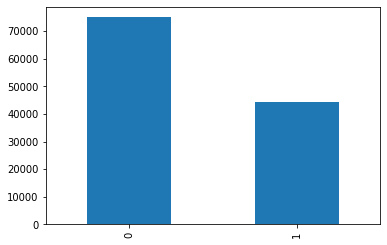

In [6]:
bookings['is_canceled'].value_counts().plot(kind='bar')

In [7]:
correlation = bookings.corr()['is_canceled'].sort_values(ascending=False)
print(correlation)

is_canceled                       1.000000
deposit_type_Non Refund           0.481507
lead_time                         0.292876
market_segment_Groups             0.221990
distribution_channel_TA/TO        0.176005
hotel_City Hotel                  0.137082
customer_type_Transient           0.133235
previous_cancellations            0.110139
booked_by_agent_True              0.102218
booked_by_company_False           0.099692
reserved_room_type_A              0.069117
adults                            0.058182
avg_daily_rate                    0.046492
meal_FB                           0.038790
stays_in_week_nights              0.025542
meal_BB                           0.012786
arrival_date_month                0.011179
arrival_date_week_number          0.008315
distribution_channel_Undefined    0.005755
reserved_room_type_H              0.005436
market_segment_Undefined          0.005336
children                          0.004862
reserved_room_type_L             -0.000550
stays_in_we

In [8]:
# Feature/Label split
X, y = bookings.iloc[:,1:], bookings.iloc[:,0]

# First model

In [12]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=.33, random_state=6)

# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier()

# Fit the classifier to the training set
xg_cl.fit(X_train, y_train)

# Predict the labels of the test set: preds
preds = xg_cl.predict(X_test)

# Compute the accuracy: accuracy
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

accuracy: 0.841230


In [ ]:
# First DMartix

In [17]:
bookings_dmatrix = xgb.DMatrix(data=X,label=y)

params = {"objective":"binary:logistic", "max_depth": 3}

cv_results = xgb.cv(dtrain=bookings_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="error", as_pandas=True, seed=123)

cv_results.head()

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.238533,0.006855,0.239460,0.009837
1,0.232766,0.001537,0.232942,0.000840
2,0.232849,0.001445,0.233001,0.000868
3,0.233126,0.001120,0.233194,0.001102
4,0.232812,0.000860,0.232866,0.001432


In [18]:
results = cv_results.tail(1)

In [19]:
print(results)

    train-error-mean  train-error-std  test-error-mean  test-error-std
49          0.182279         0.001535         0.183692        0.002255
